In [67]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from datetime import datetime

In [68]:
# read in the data
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')
data.shape

(500000, 46)

Let's see the variables in our data and decide which will we our target variable.

In [69]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

The target variable will be 'Severity', this is how important, the gravity of the accident, in order to predict how does it affect the traffic.

First we take off some variables which we consider may not explain the target.

In [70]:
data = data.drop(columns=['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Weather_Timestamp'])
data.shape

(500000, 35)

The Start_Time and End_Time variables cause some problems since they are strings and are difficult to compute. In order to avoid further problems we will create a new variable called Elapsed_Time, which will be the difference between End_Time and Start_Time.

In [71]:
data['Start_Time'].isna().sum()

0

In [72]:
data['End_Time'].isna().sum()

0

These two variables do not present any Nan, so we can proceed creating this new variable.

In [66]:
time_elapsed: list[int] = list()

for start_time, end_time in zip(data['Start_Time'], data['End_Time']):

    start_time = start_time.split('.')[0]
    end_time = end_time.split('.')[0]

    start = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    time_elapsed.append((end-start).seconds)

data['Time_Difference'] = pd.DataFrame(time_elapsed)

data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors = 'coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors = 'coerce')

data['Year'] = data['Start_Time'].dt.year
data['Month'] = data['Start_Time'].dt.month
data['Day'] = data['Start_Time'].dt.day
data['Hour'] = data['Start_Time'].dt.hour
data['Weekday'] = data['Start_Time'].dt.weekday

print(data['Day'])

data.shape

AttributeError: 'Timestamp' object has no attribute 'split'

Now that we have this information in this new variable, we can take off 'Start_Time' and 'End_Time'.

In [63]:
data_w_c = data.drop(columns=['Start_Time', 'End_Time'])
data_w_c.shape

(500000, 39)

SEARCHING NAN'S

Let's see the summary of our dataset now in order to Identify possibles Nan's.

In [64]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  int64  
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   End_Lat                279623 non-null  float64
 4   End_Lng                279623 non-null  float64
 5   Distance(mi)           500000 non-null  float64
 6   Airport_Code           498554 non-null  object 
 7   Temperature(F)         489534 non-null  float64
 8   Wind_Chill(F)          370983 non-null  float64
 9   Humidity(%)            488870 non-null  float64
 10  Pressure(in)           491072 non-null  float64
 11  Visibility(mi)         488709 non-null  float64
 12  Wind_Direction         488803 non-null  object 
 13  Wind_Speed(mph)        463013 non-null  float64
 14  Precipitation(in)      357384 non-nu

Before continuing, we will take off more variables from the dataset because we think they do not explain anything relevant. For example end_lat and end_lng are more or less the same as in the start. The rest of them are also no relevant in our point of view, in order to estimate the affected traffic.

In [65]:
data_w_c = data_w_c.drop(columns=['End_Lat','End_Lng','Airport_Code','Wind_Chill(F)','Wind_Direction','Wind_Speed(mph)','Precipitation(in)','Weather_Condition','Bump','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])
data_w_c.shape

(500000, 26)

The target value severity is categorical and Python identifies it as an int, so lets correct this. Also for the bool variables, let's make them an object.

In [12]:
data_w_c.Severity = data_w_c.Severity.astype('object')
for column in ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']:
    data_w_c[column] = data_w_c[column].astype('object')

In [14]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Severity         500000 non-null  object 
 1   Start_Lat        500000 non-null  float64
 2   Start_Lng        500000 non-null  float64
 3   Distance(mi)     500000 non-null  float64
 4   Temperature(F)   489534 non-null  float64
 5   Humidity(%)      488870 non-null  float64
 6   Pressure(in)     491072 non-null  float64
 7   Visibility(mi)   488709 non-null  float64
 8   Amenity          500000 non-null  object 
 9   Crossing         500000 non-null  object 
 10  Give_Way         500000 non-null  object 
 11  Junction         500000 non-null  object 
 12  No_Exit          500000 non-null  object 
 13  Railway          500000 non-null  object 
 14  Roundabout       500000 non-null  object 
 15  Station          500000 non-null  object 
 16  Stop             500000 non-null  obje

First we will compute the missing values for categorical variables and then for the continuous.

In [15]:
data_w_c.describe(include=['O'])

,Severity,Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
count,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
unique,4,2,2,2,2,2,2,2,2,2,2,2,1
top,2,False,False,False,False,False,False,False,False,False,False,False,False
freq,398142,493809,443747,497638,462993,498755,495680,499987,487002,485937,499534,425965,500000


It does not seem to be any missing value for the categorical values of the dataset, using the information available from the description. There are some Nan's, but these are detected by Python, so for the moment there is anything to worry about.

Now let's do the same for numerical variables.

In [16]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,500000.000000,500000.000000,500000.000000,489534.000000,488870.000000,491072.000000,488709.000000
mean,36.206421,-94.736583,0.564317,61.646254,64.834921,29.536621,9.091540
std,5.071411,17.405761,1.774872,19.000133,22.826158,1.008666,2.708083
min,24.562117,-124.497420,0.000000,-77.800000,1.000000,0.120000,0.000000
25%,33.416823,-117.233047,0.000000,49.000000,48.000000,29.370000,10.000000
50%,35.832147,-87.794365,0.029000,64.000000,67.000000,29.860000,10.000000
75%,40.082443,-80.359601,0.465000,76.000000,84.000000,30.030000,10.000000
max,48.999569,-67.484130,193.479996,207.000000,100.000000,38.440000,130.000000


The Distance variable contains some 0's, it cannot be since if there has been an accident, the lenght of the road affected by it is greater than 0. The temperature of 200 F is not possible here, so it is also a Nan, the same with temperatures smaller then -40 F.The humidity percentage contains some 1, it is very low and cannot be real so we compute it as a missing value, the same for one of 100%. The minimum of the pressure (0.12 in) is very low for a place in the Earth, so there are also missing values there. A visibility of 0 miles is also a missing value, although it could be due to a climatological adversity, the same for 130 miles.

<Axes: >

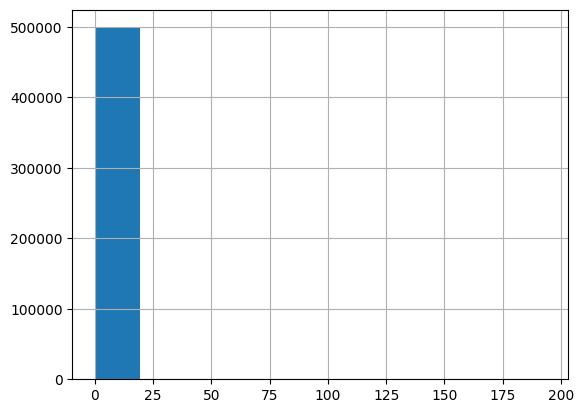

In [29]:
data_w_c['Distance(mi)'].hist()

<Axes: >

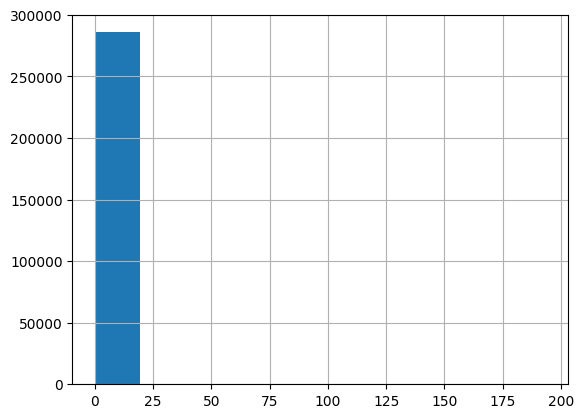

In [30]:
data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] != 0)].hist()

<Axes: >

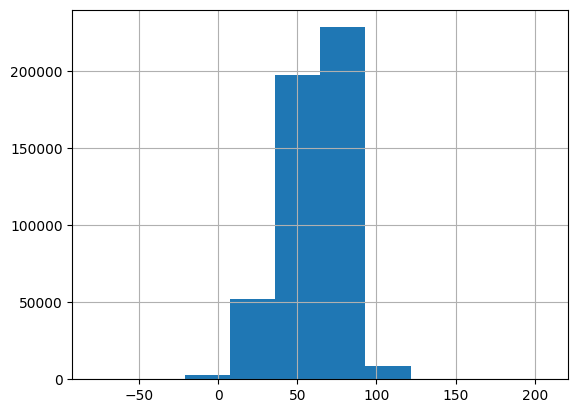

In [17]:
data_w_c['Temperature(F)'].hist()

<Axes: >

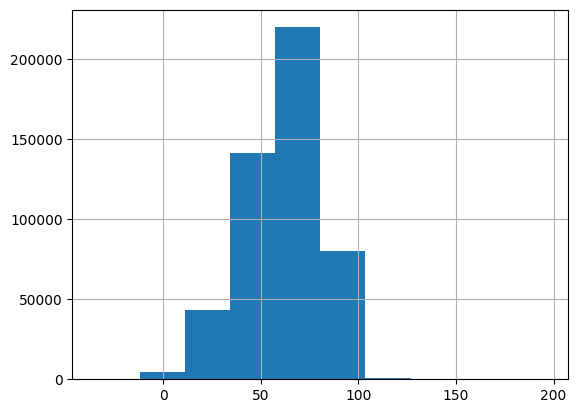

In [18]:
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] <= 200)&(data_w_c['Temperature(F)'] > -50)].hist()

<Axes: >

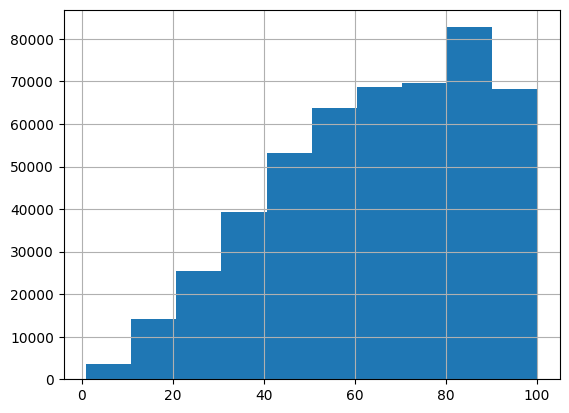

In [19]:
data_w_c['Humidity(%)'].hist()

<Axes: >

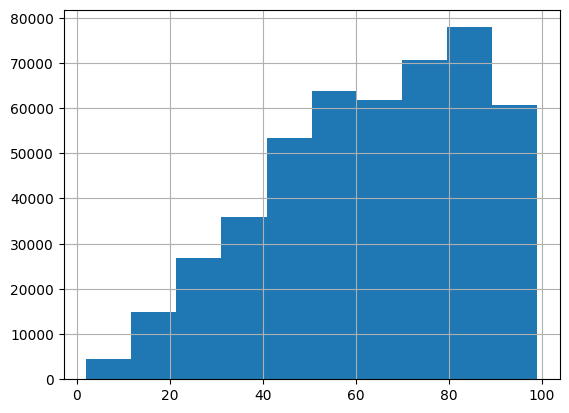

In [20]:
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] !=1)&(data_w_c['Humidity(%)'] != 100)].hist()

<Axes: >

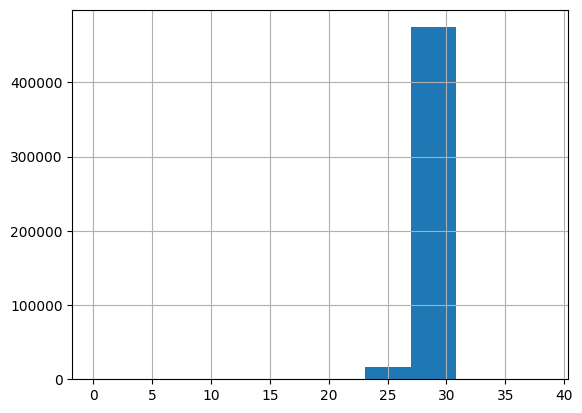

In [21]:
data_w_c['Pressure(in)'].hist()

<Axes: >

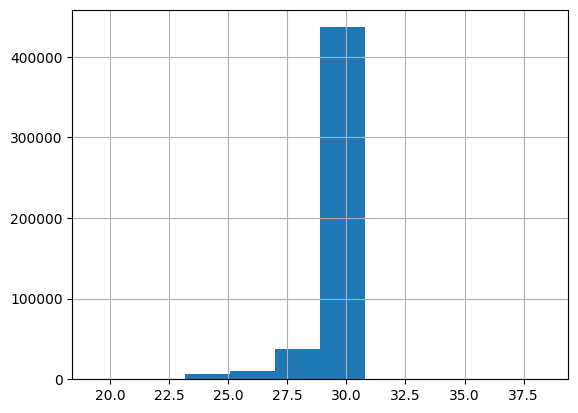

In [22]:
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] > 3)].hist()

<Axes: >

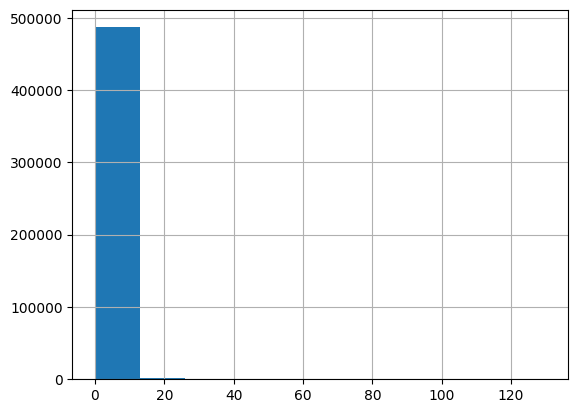

In [23]:
data_w_c['Visibility(mi)'].hist()

<Axes: >

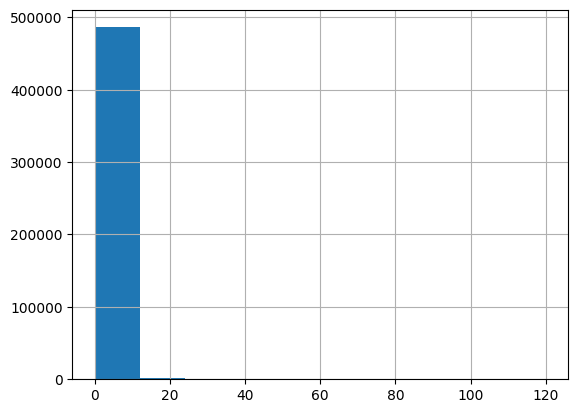

In [24]:
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] != 0) & (data_w_c['Visibility(mi)'] != 130)].hist()

In [25]:
((data_w_c['Visibility(mi)'] == 0) | (data_w_c['Visibility(mi)'] == 130)).value_counts()

Visibility(mi)
False    499481
True        519
Name: count, dtype: int64

We set the 300 mph bound because it is the aproximately point of the wind's speed in a hurricane.

Now that we have seen some missing values in our data, we will set no NA the values seen here in order to impute a prediction using the KNN algorithm.

In [31]:
data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] == 0)] = np.nan
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] >= 200)|(data_w_c['Temperature(F)'] <= -50)] = np.nan
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] == 1)|(data_w_c['Humidity(%)'] == 100)] = np.nan
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] < 3)] = np.nan
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] == 0)|(data_w_c['Visibility(mi)'] == 130)] = np.nan

C:\Users\mique\AppData\Local\Temp\ipykernel_2636\3770805335.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] == 0)] = np.nan
C:\Users\mique\AppData\Local\Temp\ipykernel_2636\3770805335.py

Let's see the difference in the description table of the numerical variables of the dataset.

In [32]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,500000.000000,500000.000000,286413.000000,489532.000000,470461.000000,491070.000000,488190.000000
mean,36.206421,-94.736583,0.985146,61.646242,63.459133,29.536735,9.100939
std,5.071411,17.405761,2.254945,18.997991,22.161575,1.007082,2.687707
min,24.562117,-124.497420,0.001000,-35.000000,2.000000,19.360000,0.060000
25%,33.416823,-117.233047,0.089000,49.000000,47.000000,29.370000,10.000000
50%,35.832147,-87.794365,0.344000,64.000000,66.000000,29.860000,10.000000
75%,40.082443,-80.359601,1.005000,76.000000,82.000000,30.030000,10.000000
max,48.999569,-67.484130,193.479996,196.000000,99.000000,38.440000,120.000000


Now we have set no NAN all those values that we have considered to be something strange, we will impute these values using the KNN algorithm.

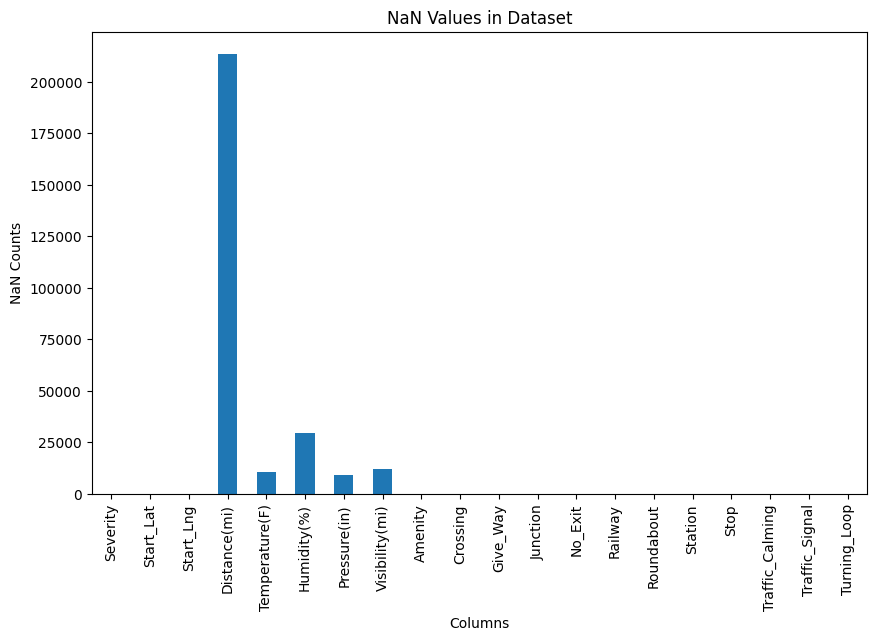

In [33]:
# nan histogram
nan_counts = data_w_c.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

In [34]:
columns_with_nan = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']
subset_data_w_c = data_w_c.drop(columns=columns_with_nan)

In [35]:
subset_data_w_c.shape

(500000, 15)

In [36]:
data_w_c.shape

(500000, 20)

In [38]:
rows_not_missing = data_w_c['Distance(mi)'].notna() & data_w_c['Temperature(F)'].notna() &  data_w_c['Humidity(%)'].notna() & data_w_c['Pressure(in)'].notna() & data_w_c['Visibility(mi)'].notna()
data_w_c_without_missing = subset_data_w_c[rows_not_missing]
data_w_c_without_missing.shape

(267513, 15)

In [39]:
#Seguir lo que se dice en el notebook 1 pre-processing
knn1 = KNeighborsRegressor(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=1)

for column in columns_with_nan:
    
    rows_column_missing = subset_data_w_c[data_w_c[column].isna()]

    if data_w_c[column].dtype == 'float' or data_w_c[column].dtype == 'int':
        knn = knn1
    elif data_w_c[column].dtype == 'object':
        knn = knn2

    knn.fit(data_w_c_without_missing, data_w_c[column][rows_not_missing])
    imputed_values = knn.predict(rows_column_missing)

    data_w_c[column][data_w_c[column].isna()] = imputed_values

data_w_c.isna().sum()  

C:\Users\mique\AppData\Local\Temp\ipykernel_2636\1192817537.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_w_c[column][data_w_c[column].isna()] = imputed_values
C:\Users\mique\AppData\Local\Temp\ipykernel_2636\1192817537.py:17: Se

Severity           0
Start_Lat          0
Start_Lng          0
Distance(mi)       0
Temperature(F)     0
Humidity(%)        0
Pressure(in)       0
Visibility(mi)     0
Amenity            0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

In [40]:
data_without_nan = data_w_c
data_without_nan.describe(include='all')

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
count,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
unique,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,1
top,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False
freq,398142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493809,443747,497638,462993,498755,495680,499987,487002,485937,499534,425965,500000
mean,NaN,36.206421,-94.736583,0.940594,61.624324,63.544054,29.530992,9.102766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,5.071411,17.405761,2.395466,18.996199,22.199646,1.018157,2.680057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,24.562117,-124.497420,0.001000,-35.000000,2.000000,19.360000,0.060000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,33.416823,-117.233047,0.049000,49.000000,47.000000,29.360000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,35.832147,-87.794365,0.260000,64.000000,66.000000,29.850000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,40.082443,-80.359601,0.915000,76.000000,82.000000,30.030000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our data has no Nan's, those who where have been imputated, now let's focus on the outliers.

FINDING OUTLIERS

It is important to identify these values, in order to take them into account when fitting models. Some of these models are sensitive to outliers. 

First let's see the variable Distance(mi), this has a clear outlier, it's max.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

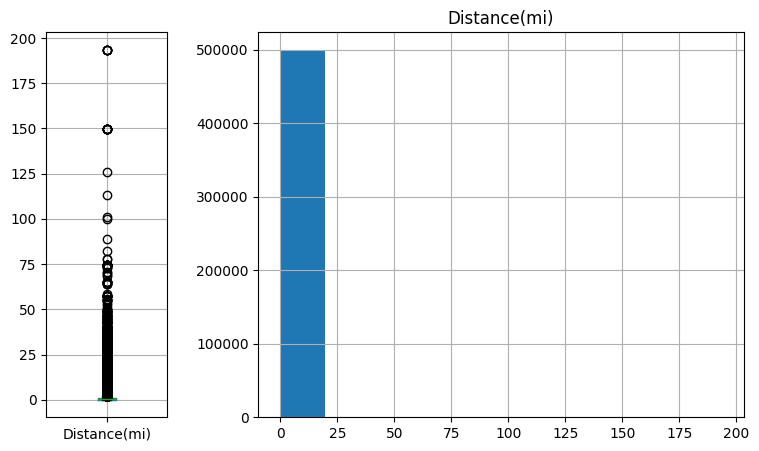

In [41]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan.boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan.hist(column='Distance(mi)',ax=axes[1])

There are obviously a lot of values that do not represent the correct distribution of our variable.

Let's use the IQR to improve this. Using LocalOutlierFactor, we have seen that it requires a lot of computational time and does not improve the results given by the IQR, so we will use this strategy.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

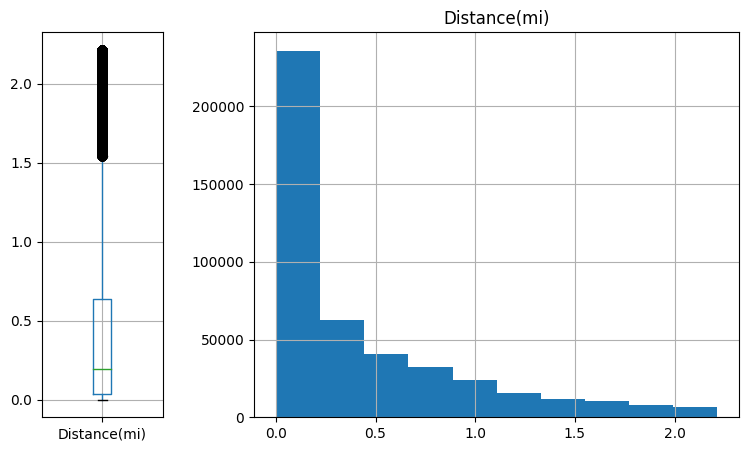

In [43]:
Q1 = data_without_nan['Distance(mi)'].quantile(0.25)
Q3 = data_without_nan['Distance(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan['Distance(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan['Distance(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan[~(small_out | big_out)].boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan[~(small_out | big_out)].hist(column='Distance(mi)',ax=axes[1])

In [44]:
data_without_nan[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,447585.000000,447585.000000,447585.000000,447585.000000,447585.000000,447585.000000,447585.000000
mean,36.082821,-94.988922,0.420975,61.909199,63.433234,29.556184,9.130325
std,5.073589,17.458738,0.513800,18.793326,22.172501,0.972116,2.656168
min,24.562117,-124.497420,0.001000,-35.000000,2.000000,19.520000,0.060000
25%,33.258566,-117.310844,0.038000,50.000000,47.000000,29.390000,10.000000
50%,35.694256,-87.956100,0.193000,64.000000,66.000000,29.860000,10.000000
75%,39.981843,-80.385375,0.640000,76.000000,82.000000,30.030000,10.000000
max,48.999569,-67.484130,2.214000,196.000000,99.000000,38.440000,120.000000


In [45]:
data_without_nan_out1 = data_without_nan[~(small_out | big_out)]

Visibility:

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

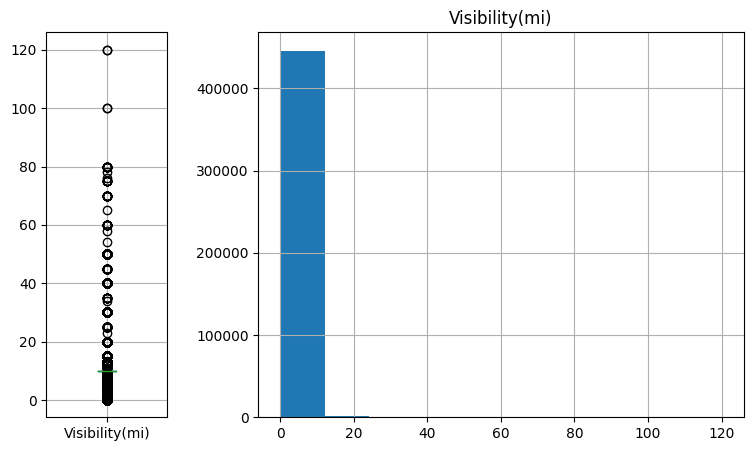

In [46]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1.boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1.hist(column='Visibility(mi)',ax=axes[1])

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

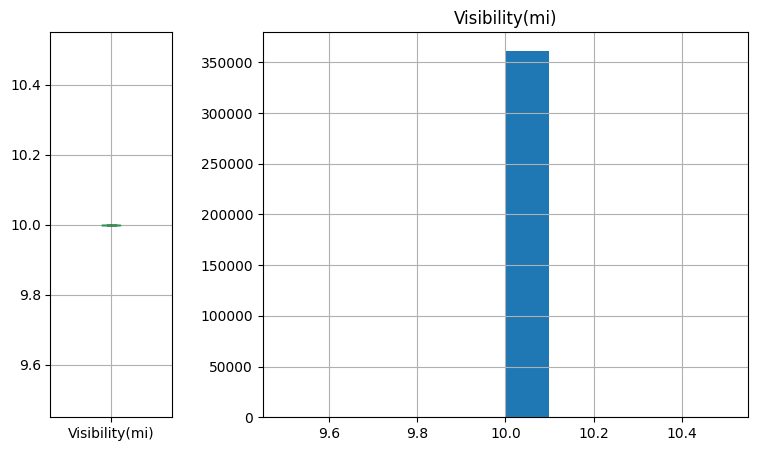

In [47]:
Q1 = data_without_nan_out1['Visibility(mi)'].quantile(0.25)
Q3 = data_without_nan_out1['Visibility(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out1['Visibility(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out1['Visibility(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1[~(small_out | big_out)].boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1[~(small_out | big_out)].hist(column='Visibility(mi)',ax=axes[1])

All data from Visibility is concentrated around 10 mi.

In [49]:
data_without_nan_out1[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,361564.000000,361564.000000,361564.000000,361564.000000,361564.000000,361564.000000,361564.0
mean,35.869479,-94.730225,0.414399,63.732838,59.741282,29.565434,10.0
std,5.116691,17.395602,0.509635,18.392206,21.237662,0.973713,0.0
min,24.562117,-124.497420,0.001000,-35.000000,2.000000,19.520000,10.0
25%,32.912550,-117.202711,0.038000,52.000000,45.000000,29.400000,10.0
50%,35.411430,-87.648190,0.188000,66.000000,61.000000,29.870000,10.0
75%,39.825433,-80.362602,0.625000,78.000000,77.000000,30.040000,10.0
max,48.991585,-67.484130,2.214000,196.000000,99.000000,38.440000,10.0


In [50]:
data_without_nan_out2 = data_without_nan_out1[~(small_out | big_out)]

Temperature:

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

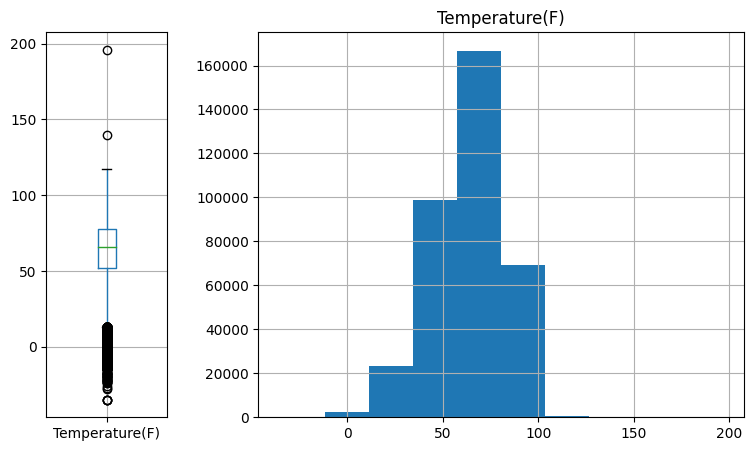

In [51]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2.boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2.hist(column='Temperature(F)',ax=axes[1])

It seems well distributed. However, it seems there are some outliers. We will do the same for Wind_Chill since from the describe of the dataset, it is almost equally distributed as temperature.

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

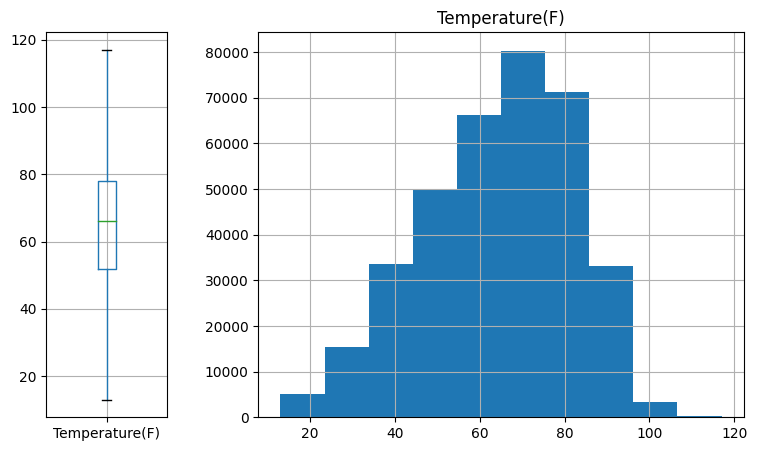

In [52]:
Q1 = data_without_nan_out2['Temperature(F)'].quantile(0.25)
Q3 = data_without_nan_out2['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out2['Temperature(F)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out2['Temperature(F)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2[~(small_out | big_out)].boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2[~(small_out | big_out)].hist(column='Temperature(F)',ax=axes[1])

It is better now.

In [53]:
data_without_nan_out2[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,358770.000000,358770.000000,358770.000000,358770.000000,358770.000000,358770.000000,358770.0
mean,35.813474,-94.758924,0.413134,64.200778,59.667241,29.567477,10.0
std,5.091771,17.440851,0.508950,17.662913,21.276479,0.966129,0.0
min,24.562117,-124.497420,0.001000,13.000000,2.000000,19.520000,10.0
25%,32.893762,-117.234685,0.038000,52.000000,44.000000,29.410000,10.0
50%,35.337339,-87.601720,0.187000,66.000000,61.000000,29.870000,10.0
75%,39.773277,-80.354233,0.622000,78.000000,77.000000,30.040000,10.0
max,48.991585,-67.484130,2.214000,117.000000,99.000000,38.440000,10.0


In [54]:
data_without_nan_out3 = data_without_nan_out2[~(small_out | big_out)]

Humidity:

array([<Axes: title={'center': 'Humidity(%)'}>], dtype=object)

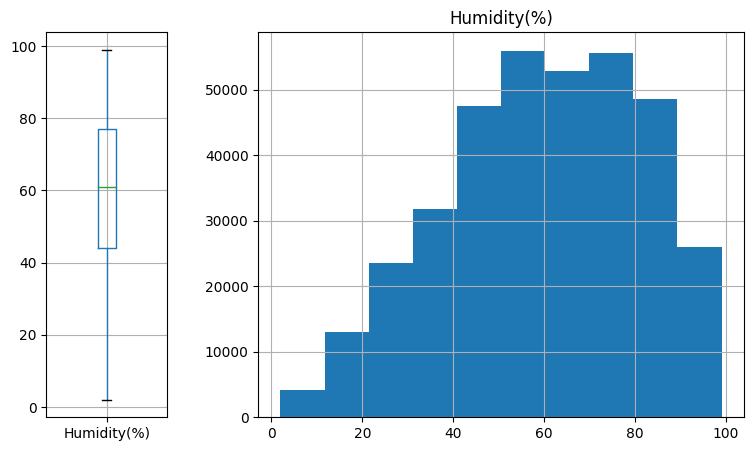

In [55]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out3.boxplot(column='Humidity(%)',ax=axes[0])
data_without_nan_out3.hist(column='Humidity(%)',ax=axes[1])

Humidity is well distributed.

Time_Difference:

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

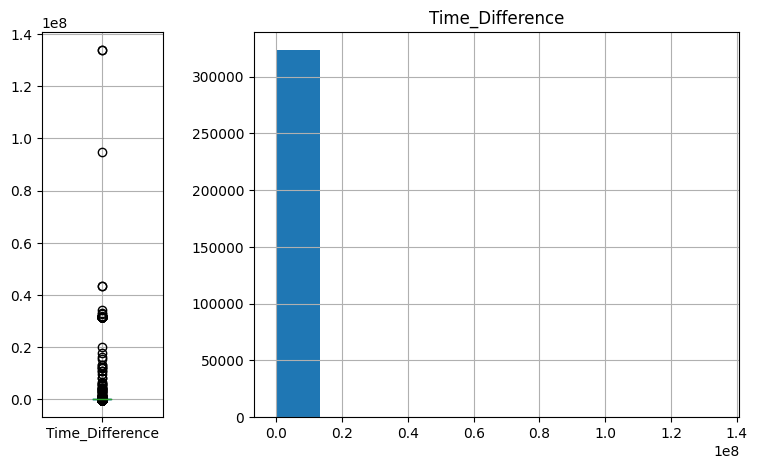

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6.boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6.hist(column='Time_Difference',ax=axes[1])

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

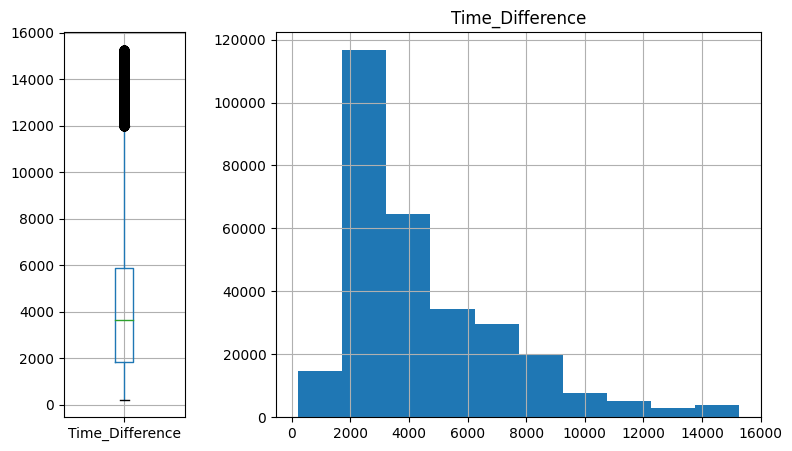

In [ ]:
Q1 = data_without_nan_out6['Time_Difference'].quantile(0.25)
Q3 = data_without_nan_out6['Time_Difference'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out6['Time_Difference'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out6['Time_Difference'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6[~(small_out | big_out)].boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6[~(small_out | big_out)].hist(column='Time_Difference',ax=axes[1])

In [ ]:
data_without_nan_out6[~(small_out | big_out)].describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.0,299327.000000,299327.0,299327.000000
mean,35.724773,-94.781265,35.674699,-94.749543,0.146347,64.716406,63.889803,59.126464,29.559269,10.0,8.445881,0.0,4418.941616
std,4.979161,17.396519,4.943341,17.440721,0.265089,17.430938,19.393081,21.063318,0.956906,0.0,3.931528,0.0,2860.134741
min,24.562117,-124.494330,24.570110,-124.495392,0.000000,13.000000,8.000000,2.000000,19.520000,10.0,1.000000,0.0,210.000000
25%,32.900779,-117.229658,32.893150,-117.305577,0.000000,53.000000,52.000000,44.000000,29.380000,10.0,5.800000,0.0,1826.000000
50%,35.220367,-87.336800,35.188631,-87.295737,0.000000,66.900000,67.000000,60.000000,29.860000,10.0,8.000000,0.0,3617.000000
75%,39.546116,-80.385739,39.341020,-80.392713,0.160000,78.100000,79.000000,76.000000,30.040000,10.0,10.400000,0.0,5891.000000
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.000000,115.000000,99.000000,38.440000,10.0,20.000000,0.0,15270.000000


In [ ]:
data_without_nan_out = data_without_nan_out6[~(small_out | big_out)]

Every numerical variable has been treated from outliers.

GAUSSIANITY AND TRANSFORMATIONS

Let's see if every numerical variable is distributed with a gaussian.